# Topic Extraction in RSS-Feed Corpus

- Author:      Johannes Maucher
- Last update: 2018-11-16

In the [notebook 01gensimDocModelSimple](01gensimDocModelSimple.ipynb) the concepts of dictionaries, document models, tf-idf and similarity have been described using an example of a samll document collection. Moreover, in [notebook 02LatentSemanticIndexing](02LatentSemanticIndexing.ipynb) LSI based topic extraction and document clustering have also been introduced by a small playground example.

The current notebook applies these concepts to a real corpus of RSS-Feeds, which has been generated and accessed in previous notebooks of this lecture:

## Read documents from a corpus 

The contents of the RSS-Fedd corpus are imported by NLTK's `CategorizedPlaintextCorpusReader` as already done in previous notebooks of this lecture:

In [1]:
#!pip install wordcloud

In [2]:
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.corpus import stopwords
stopwordlist=stopwords.words('german')
from wordcloud import WordCloud

rootDir="../01access/GERMAN"
filepattern=r"(?!\.)[\w_]+(/RSS/FeedText/)[\w-]+/[\w-]+\.txt"
#filepattern=r"(?!\.)[\w_]+(/RSS/FullText/)[\w-]+/[\w-]+\.txt"
catpattern=r"([\w_]+)/.*"
rssreader=CategorizedPlaintextCorpusReader(rootDir,filepattern,cat_pattern=catpattern)

In [3]:
singleDoc=rssreader.paras(categories="TECH")[0]
print("The first paragraph:\n",singleDoc)
print("Number of paragraphs in the corpus: ",len(rssreader.paras(categories="TECH")))

The first paragraph:
 [['Zur', 'kalten', 'Jahreszeit', 'nur', '1', '%', 'Akku', '?'], ['Dieser', 'Befehl', 'hält', 'den', 'iPhone', '-', 'Akku', 'länger', 'am', 'Leben', 'Im', 'Auto', ',', 'bei', 'einem', 'wichtigen', 'Anruf', 'oder', 'wenn', 'man', 'abends', 'unterwegs', 'ist', ':', 'Der', 'Akku', 'des', 'Smartphones', 'geht', 'immer', 'dann', 'leer', ',', 'wenn', 'man', 'ihn', 'am', 'dringendsten', 'braucht', '.'], ['Wir', 'zeigen', 'Ihnen', 'einen', 'praktischen', 'Trick', ',', 'mit', 'dem', 'Sie', 'die', 'Laufzeit', 'Ihres', 'iPhones', 'auch', 'bei', 'niedrigem', 'Batteriestand', 'verlängern', 'können', '.']]
Number of paragraphs in the corpus:  160


In [4]:
techdocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="TECH")]
print("Number of documents in category Tech: ",len(techdocs))

Number of documents in category Tech:  160


In [5]:
generaldocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="GENERAL")]
print("Number of documents in category General: ",len(generaldocs))

Number of documents in category General:  334


In [6]:
alldocs=techdocs+generaldocs
print("Total number of documents: ",len(alldocs))

Total number of documents:  494


### Remove duplicate news

In [7]:
def removeDuplicates(nestedlist):
    listOfTuples=[tuple(liste) for liste in nestedlist]
    uniqueListOfTuples=list(set(listOfTuples))
    return [list(menge) for menge in uniqueListOfTuples]

In [8]:
techdocs=removeDuplicates(techdocs)
generaldocs=removeDuplicates(generaldocs)
alldocs=removeDuplicates(alldocs)
print("Number of unique documents in category Tech: ",len(techdocs))
print("Number of unique documents in category General: ",len(generaldocs))
print("Total number of unique documents: ",len(alldocs))

Number of unique documents in category Tech:  160
Number of unique documents in category General:  285
Total number of unique documents:  445


In [9]:
alltechString=" ".join([w for doc in techdocs for w in doc])
print(len(alltechString))
allgeneralString=" ".join([w for doc in generaldocs for w in doc])
print(len(allgeneralString))

30680
53511


(-0.5, 399.5, 199.5, -0.5)

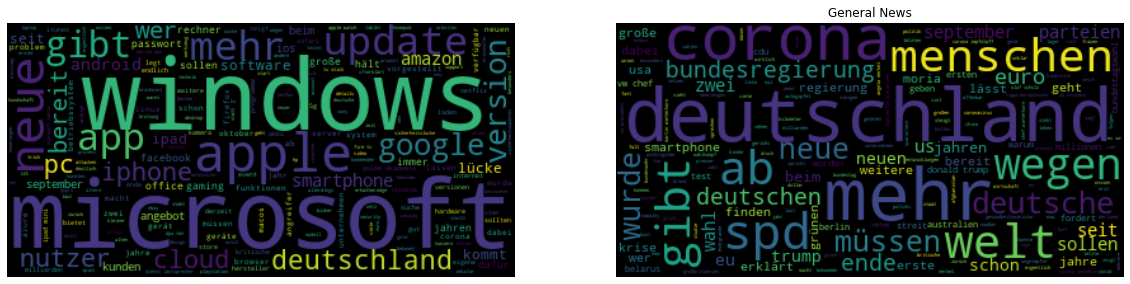

In [10]:
wordcloudTech=WordCloud().generate(alltechString)
wordcloudGeneral=WordCloud().generate(allgeneralString)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,18))
plt.title("Tech News")
plt.subplot(1,2,1)
plt.imshow(wordcloudTech, interpolation='bilinear')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(wordcloudGeneral, interpolation='bilinear')
plt.title("General News")
plt.axis("off")

## Gensim-representation of imported RSS-feeds 

In [11]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(alldocs)
dictionary.save('feedwordsDE.dict') # store the dictionary, for future reference
#print(dictionary.token2id)
print(len(dictionary))

4845


In [12]:
firstdoc=techdocs[0]
print(firstdoc)
firstVec = dictionary.doc2bow(firstdoc)
print("Sparse BoW representation of single document: %s"%firstVec)
w1='windows'
w2='apple'
w3='system'
print("Index of word %s is %d"%(w1,dictionary.token2id[w1]))
print("Index of word %s is %d"%(w2,dictionary.token2id[w2]))
print("Index of word %s is %d"%(w3,dictionary.token2id[w3]))

['superpack', 'facebook', 'nutzt', 'compiler', 'technik', 'app', 'kompression', 'superpack', 'facebook', 'android', 'apps', 'rund', '20', 'prozent', 'kleiner', 'packen', 'bisher', 'möglich', 'macht', 'compiler', 'technik', 'facebook', 'soziales', 'netz']
Sparse BoW representation of single document: [(207, 1), (255, 3), (410, 1), (710, 1), (780, 1), (946, 1), (1189, 1), (1190, 1), (1236, 2), (1278, 1), (1529, 1), (1802, 1), (1803, 1), (1804, 1), (1805, 2), (1806, 1), (1807, 1), (1808, 1), (1809, 2)]
Index of word windows is 478
Index of word apple is 48
Index of word system is 493


Sparse BoW representation of entire tech-corpus and entire general-news-corpus: 

In [13]:
techcorpus = [dictionary.doc2bow(doc) for doc in techdocs]
generalcorpus = [dictionary.doc2bow(doc) for doc in generaldocs]

In [14]:
print(generaldocs[:3])

[['ezb', 'währungshüter', 'alarmiert', 'wegen', 'stärke', 'euro', 'anfang', 'september', 'euro', 'marke', '20', 'dollar', 'gestiegen', 'ersten', 'mal', 'seit', 'zwei', 'jahren', 'starke', 'währung', 'verteuert', 'exporte', 'bringt', 'inflationsziel', 'weite', 'ferne', 'währungshüter', 'ezb', 'alarmiert'], ['brand', 'new', 'diamond', '":', 'feuer', 'öltanker', 'sri', 'lanka', 'gelöscht', 'feuer', 'öltanker', 'new', 'diamond', 'sri', 'lanka', 'konnte', 'gelöscht', 'marine', 'diesel', 'meer', 'entdeckt', 'rund', 'kilometer', 'schiff', 'entfernt'], ['kritik', 'polizei', 'schüssen', '13', 'jährigen', 'autisten', 'utah', 'polizei', 'us', 'stadt', 'salt', 'lake', 'city', 'sieht', 'scharfer', 'kritik', 'ausgesetzt', 'nachdem', 'psychisch', 'instabilen', '13', 'jährigen', 'mehreren', 'schüssen', 'schwer', 'verletzt', 'mutter', 'jungen', 'beamten', 'hilfe', 'gerufen']]


## Find similiar documents

In [15]:
index = similarities.SparseMatrixSimilarity(techcorpus, num_features=len(dictionary))

In [16]:
sims = index[firstVec]
#print(list(enumerate(sims)))
simlist = sims.argsort()
print(simlist)
mostSimIdx=simlist[-2]

[159 135  88  87  86  85  84  83  82  80 158  78  77  90  76  74  73 140
  71  70 141  68  67  66  65 142 143 138  91  92 134 120 119 118 117 116
 124 114 113 126 127 110 129 108 107 130 105 104 103 102 101 100  99  98
  97  96  95 131  62 121  61 144  27  26  25  24 154  22  21  20  19  18
  17  16  15 156  13  12  11  10   9   8   7   6   5 157   3   2   1 153
  29 151  31  58  57  56  55  54 145  52  51  50 146  48  47  46  60  45
 149  42  41  40  39  38  37  36  35  33 150 148 122  34 137  79 155  28
 111 109  81  94 147  44 139 106  59  14  64  32  63  53  43 136 115 152
 123  93  69  75 133 125  49 112  89   4 128  72 132  30  23   0]


In [17]:
print("Refernce document is:\n",firstdoc)
print("Most similar document:\n",techdocs[mostSimIdx])

Refernce document is:
 ['superpack', 'facebook', 'nutzt', 'compiler', 'technik', 'app', 'kompression', 'superpack', 'facebook', 'android', 'apps', 'rund', '20', 'prozent', 'kleiner', 'packen', 'bisher', 'möglich', 'macht', 'compiler', 'technik', 'facebook', 'soziales', 'netz']
Most similar document:
 ['sonderregeln', 'promis', 'facebook', 'wenig', 'moderation', 'dank', 'xcheck', 'wer', 'facebook', 'erlaubte', 'beiträge', 'teilt', 'sperrung', 'account', 'löschung', 'befürchten', 'promis', 'gelten', 'regeln', 'enthüllt', 'us', 'zeitung']


## Find topics by Latent Semantic Indexing (LSI)
### Generate tf-idf model of corpus

In [18]:
tfidf = models.TfidfModel(techcorpus)
corpus_tfidf = tfidf[techcorpus]
print("Display TF-IDF- Model of first 2 documents of the corpus")
for doc in corpus_tfidf[:2]:
    print(doc)

Display TF-IDF- Model of first 2 documents of the corpus
[(207, 0.16934310212843717), (255, 0.46102179711877644), (410, 0.10714649049259986), (710, 0.19612972475158713), (780, 0.14255647950528721), (946, 0.12688730974977552), (1189, 0.14255647950528721), (1190, 0.15367393237292548), (1236, 0.30734786474585096), (1278, 0.15367393237292548), (1529, 0.16934310212843717), (1802, 0.13393311311574982), (1803, 0.14255647950528721), (1804, 0.14255647950528721), (1805, 0.39225944950317426), (1806, 0.19612972475158713), (1807, 0.19612972475158713), (1808, 0.19612972475158713), (1809, 0.39225944950317426)]
[(60, 0.1599355006094432), (342, 0.12585756504600912), (501, 0.1599355006094432), (547, 0.12048699301190226), (1469, 0.1762431233160749), (1700, 0.20412118846816124), (1959, 0.13939032576043167), (2436, 0.1762431233160749), (2513, 0.1599355006094432), (2745, 0.1762431233160749), (2853, 0.3524862466321498), (4053, 0.4082423769363225), (4054, 0.20412118846816124), (4055, 0.20412118846816124), (40

### Generate LSI model from tf-idf model

In [19]:
techdictionary = corpora.Dictionary(techdocs)

In [20]:
NumTopics=20
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=NumTopics) # initialize an LSI transformation

In [21]:
corpus_lsi = lsi[corpus_tfidf]

Display first 10 topics:

In [22]:
lsi.print_topics(10)

[(0,
  '-0.413*"windows" + -0.403*"microsoft" + -0.362*"11" + -0.132*"apple" + -0.115*"oktober" + -0.114*"neue" + -0.113*"office" + -0.106*"nutzer" + -0.102*"10" + -0.100*"betriebssystem"'),
 (1,
  '0.507*"apple" + 0.273*"ipad" + -0.205*"microsoft" + 0.205*"15" + 0.180*"mini" + 0.160*"watch" + 0.153*"ios" + -0.129*"11" + 0.129*"homepod" + 0.111*"tvos"'),
 (2,
  '0.337*"azure" + 0.267*"linux" + -0.240*"11" + 0.236*"cloud" + -0.228*"windows" + 0.186*"lücke" + 0.183*"kritische" + 0.174*"omigod" + 0.154*"updates" + 0.134*"root"'),
 (3,
  '-0.281*"google" + -0.237*"android" + -0.230*"12" + 0.194*"ipad" + -0.149*"itunes" + -0.148*"firefox" + 0.144*"microsoft" + -0.143*"version" + -0.142*"deutschland" + 0.127*"mini"'),
 (4,
  '0.414*"ipad" + 0.213*"mini" + 0.200*"test" + -0.194*"apple" + 0.186*"apples" + 0.186*"praxis" + 0.148*"10" + -0.131*"watch" + 0.128*"deal" + 0.121*"leistung"'),
 (5,
  '-0.268*"12" + -0.212*"itunes" + -0.185*"android" + -0.179*"google" + 0.152*"update" + 0.148*"safari" 

### Determine the most relevant documents for a selected topic

Generate a numpy array `docTopic`. The entry in row $i$, column $j$ of this array is the relevance value for topic $j$ in document $i$.

In [23]:
import numpy as np
numdocs= len(corpus_lsi)
docTopic=np.zeros((numdocs,NumTopics))

In [24]:
for d,doc in enumerate(corpus_lsi): # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
    for t,top in enumerate(doc):
        docTopic[d,t]=top[1]
print(docTopic.shape)
print(docTopic)

(160, 20)
[[-0.05482824  0.03553555  0.0058951  ... -0.13430049  0.06773444
   0.33363059]
 [-0.05351748  0.02114523 -0.01251187 ... -0.0950214   0.11254642
  -0.07595583]
 [-0.03097831  0.01766805 -0.00664991 ...  0.40062262  0.04499268
   0.35981838]
 ...
 [-0.01138793  0.0234574   0.01036627 ... -0.00385527 -0.06643598
   0.04974784]
 [-0.26736743 -0.12908631  0.10443158 ...  0.02809054  0.01105446
  -0.01495262]
 [-0.0218476   0.00758622 -0.01240698 ... -0.01503899 -0.03445081
   0.00561354]]


Select an arbitrary topic-id and determine the documents, which have the highest relevance value for this topic:

In [25]:
topicId=7 #select an arbitrary topic-id
topicRelevance=docTopic[:,topicId]

In [26]:
docsoftopic= np.array(topicRelevance).argsort()
relevanceValue= np.sort(topicRelevance)
print(docsoftopic) #most relevant document for selected topic is at first position
print(relevanceValue) #highest relevance document/topic-relevance-value is at first position

[ 62 126  28 158 101  69  25  99 123 119  54 121  19  79  95 124  53 146
  38  67 100 150  78  14 156 141  52   3 143 120  43 135  41 108 149 144
  68  33  31  97  55 137  80 136 155  22  26 114  15  89 104  86  50 147
  92 115 138  81  12 130 106 153  23   2 102  61  18 113  87  32  77  13
  60   1  11 111 145   6 116  29 127  83 118  30 103  65 129  47 117  10
  91  72   0 105 109   5  45 152  82  90 107 148   4 134  57 159  40  48
  71 154   7 122  46  98  36 142 131  93 132  34  27 125  63 133  75  59
  37 157 110  51 140  94  44  96  21   9  16  35  17  39   8 128  49  24
 112  42  70  56  58  66  84  73  88  85 151  74 139  64  20  76]
[-2.14953005e-01 -2.10711440e-01 -2.03848410e-01 -2.01961061e-01
 -1.72201854e-01 -1.71277904e-01 -1.68211596e-01 -1.61545241e-01
 -1.54071607e-01 -1.50022149e-01 -1.45596183e-01 -1.44890576e-01
 -1.38659198e-01 -1.34984045e-01 -1.28227316e-01 -1.21627598e-01
 -1.21147056e-01 -1.16547939e-01 -1.09831745e-01 -1.09715781e-01
 -1.07610862e-01 -1.05597

In [27]:
TOP=8
print("Selected Topic:\n",lsi.show_topic(topicId))
print("#"*50)
print("Docs with the highest negative value w.r.t the selected topic")
for idx in docsoftopic[:TOP]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])
print("#"*50)
print("Docs with the highest positive value w.r.t the selected topic")
for idx in docsoftopic[-TOP:]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])

Selected Topic:
 [('firefox', 0.21448170783918122), ('macos', 0.2126892177920755), ('safari', 0.20832576988369442), ('browser', 0.16163390171637942), ('passwort', -0.13624155586097667), ('itunes', 0.12277492527702388), ('deutschland', -0.12024180147331977), ('gaming', -0.1183823281259556), ('microsoft', -0.11757197137980266), ('version', 0.11324822188989367)]
##################################################
Docs with the highest negative value w.r.t the selected topic
--------------------
62 
 ['systems', 'google', 'versprechen', 'souveräne', 'cloud', 'deutschland', 'scheitern', 'microsoft', 'cloud', 'deutschland', 'kooperiert', 'telekom', 'google', 'schon', '2022', 'souveräne', 'cloud', 'deutsche', 'kunden', 'starten']
--------------------
126 
 ['asus', 'gaming', 'monitor', 'deal', 'amazon', 'ebay', 'leistungsstarken', 'gaming', 'pc', 'start', 'passende', 'monitor', 'fehlt', 'amazon', 'ebay', 'bekommen', 'tolles', 'modell', 'asus', 'vorzugspreis']
--------------------
28 
 ['micros

In [28]:
import gensim


In [29]:
lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=20, id2word = dictionary)

In [30]:
#!pip install pyLDAvis

In [31]:
#import pyLDAvis.gensim as gensimvis
#import pyLDAvis

#vis_en = gensimvis.prepare(lda, corpus_tfidf, dictionary)
#pyLDAvis.display(vis_en)